# Qwen3でのentropy/MI測定
このノートブックでは、Qwen3モデルのmacOS環境での動作を検証し、シンプルなタスクにおけるentropy/MIの値の挙動を確認します。

## 検証項目
1. 🤖 Qwen3の動作確認（chat_templateの適用なし）
2. 🔄 chat_templateの適用（chat_templateの適用方法を確認。結果がどのようにかわるかを観察）
3. 🧠 Thinking Modeの適用（thinkin modelの有り無しでの違いの確認）
4. entropy/MIを用いた回帰



## 🛠 Step 0: モデルの準備

In [1]:
import os
import re
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import NearestNeighbors
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


/Users/s20406/script/seminar/icml/PhiMesaSI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 0: モデルの準備
export_dir = "result"
t0 = time.time()
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✅ モデル`{model_name}`読み込み完了 in {time.time() - t0:.2f}秒")


✅ モデル`Qwen/Qwen3-0.6B`読み込み完了 in 2.35秒


In [3]:
# Mutual Information Calculation Functions
def calculate_mutual_information_knn(state1, state2, k=3):
    """
    Calculate mutual information between two hidden states using k-NN method.
    This is more appropriate for continuous variables than discretization.
    
    Args:
        state1, state2: torch tensors representing hidden states
        k: number of nearest neighbors for estimation
    
    Returns:
        float: mutual information value
    """
    # Flatten the states to 1D
    flat1 = state1.flatten().detach().cpu().numpy()
    flat2 = state2.flatten().detach().cpu().numpy()
    
    # Ensure same length
    min_len = min(len(flat1), len(flat2))
    flat1 = flat1[:min_len]
    flat2 = flat2[:min_len]
    
    # Use sklearn's mutual_info_regression for continuous variables
    # Reshape for sklearn (samples, features)
    X = flat1.reshape(-1, 1)
    y = flat2
    
    # Calculate mutual information
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)[0]
    
    return mi

def calculate_mutual_information_discretized(state1, state2, bins=50):
    """
    Calculate mutual information using discretization (binning) method.
    This is the original method, kept for comparison.
    
    Args:
        state1, state2: torch tensors representing hidden states
        bins: number of bins for discretization
    
    Returns:
        float: mutual information value
    """
    # Flatten the states to 1D
    flat1 = state1.flatten().detach().cpu().numpy()
    flat2 = state2.flatten().detach().cpu().numpy()
    
    # Ensure same length
    min_len = min(len(flat1), len(flat2))
    flat1 = flat1[:min_len]
    flat2 = flat2[:min_len]
    
    # Discretize the continuous values into bins
    hist1, bin_edges1 = np.histogram(flat1, bins=bins)
    hist2, bin_edges2 = np.histogram(flat2, bins=bins)
    
    # Create joint histogram
    joint_hist, _, _ = np.histogram2d(flat1, flat2, bins=bins)
    
    # Normalize to get probabilities
    joint_prob = joint_hist / np.sum(joint_hist)
    prob1 = hist1 / np.sum(hist1)
    prob2 = hist2 / np.sum(hist2)
    
    # Calculate mutual information
    mi = 0.0
    for i in range(bins):
        for j in range(bins):
            if joint_prob[i, j] > 0 and prob1[i] > 0 and prob2[j] > 0:
                mi += joint_prob[i, j] * np.log2(joint_prob[i, j] / (prob1[i] * prob2[j]))
    
    return mi

def compute_mutual_information_matrix(hidden_states_list, method='knn', split_index=1):
    """
    Compute n×n mutual information matrix for n hidden states.
    
    Args:
        hidden_states_list: list of hidden states (tensors)
        method: 'knn' for k-nearest neighbors, 'discretized' for binning, or 'phi' for integrated information
        split_index: integer index to split states for phi calculation (default 1)
    
    Returns:
        numpy array: n×n mutual information matrix
    """
    n = len(hidden_states_list)
    mi_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                # Self-mutual information (entropy)
                flat_state = hidden_states_list[i].flatten().detach().cpu().numpy()
                hist, _ = np.histogram(flat_state, bins=50)
                prob = hist / np.sum(hist)
                prob = prob[prob > 0]  # Remove zero probabilities
                mi_matrix[i, j] = entropy(prob, base=2)
            else:
                if method == 'knn':
                    mi_matrix[i, j] = calculate_mutual_information_knn(
                        hidden_states_list[i], 
                        hidden_states_list[j]
                    )
                else:  # discretized
                    mi_matrix[i, j] = calculate_mutual_information_discretized(
                        hidden_states_list[i], 
                        hidden_states_list[j]
                    )
    
    return mi_matrix

def visualize_mi_matrix(mi_matrix, title="Mutual Information Matrix", save_path=None):
    """Visualize the mutual information matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    im = plt.imshow(mi_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Mutual Information')
    plt.title(title)
    plt.xlabel('State Index')
    plt.ylabel('State Index')
    
    # Add text annotations
    for i in range(mi_matrix.shape[0]):
        for j in range(mi_matrix.shape[1]):
            plt.text(j, i, f'{mi_matrix[i, j]:.3f}', 
                    ha='center', va='center', color='white', fontsize=8)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        os.makedirs(export_dir, exist_ok=True)
        plt.savefig(os.path.join(export_dir, save_path), dpi=300, bbox_inches='tight')
        print(f"📊 Figure saved to: {os.path.join(export_dir, save_path)}")
    
    plt.show()

print("✅ Mutual information calculation functions loaded!")
print("📝 Available methods:")
print("   - 'knn': k-Nearest Neighbors method (recommended for continuous variables)")
print("   - 'discretized': Binning method (traditional approach)")
print("💡 The 'knn' method is more appropriate for continuous hidden states!")


✅ Mutual information calculation functions loaded!
📝 Available methods:
   - 'knn': k-Nearest Neighbors method (recommended for continuous variables)
   - 'discretized': Binning method (traditional approach)
💡 The 'knn' method is more appropriate for continuous hidden states!


In [4]:
truth_prompt = "Tell me a truth about artificial intelligence. Can you explain what it is?"
lie_prompt = "Tell me a lie about artificial intelligence. Can you explain what it is?"


In [5]:
NUM_RESPONSES_PER_OBJECT = 10
NUM_OBJECTS_TRAIN = 5
NUM_OBJECTS_VALID = 2

objects = [
    "human brain",
    "quantum computing",
    "climate change",
    "space exploration",
    "chromosomes",
    "black holes",
    "genetic engineering",
    "nanotechnology",
    "renewable energy",
    "artificial intelligence",
]


In [28]:
# Data structures for storing multiple responses
print("🗄️ Initializing data collection structures...")

# Dictionary to store all responses: object -> prompt_type -> response_idx -> response_text
all_responses = {}

# Dictionary to store hidden states: object -> prompt_type -> response_idx -> hidden_states
all_hidden_states = {}

# Dictionary to store MI matrices: object -> prompt_type -> response_idx -> mi_matrix
all_mi_matrices = {}

# Initialize for each object
for obj in objects:
    all_responses[obj] = {"truth": {}, "lie": {}}
    all_hidden_states[obj] = {"truth": {}, "lie": {}}
    all_mi_matrices[obj] = {"truth": {}, "lie": {}}

print(f"✅ Data structures initialized for {len(objects)} objects")
print(f"   Each object will have {NUM_RESPONSES_PER_OBJECT} truth responses and {NUM_RESPONSES_PER_OBJECT} lie responses")


🗄️ Initializing data collection structures...
✅ Data structures initialized for 10 objects
   Each object will have 10 truth responses and 10 lie responses


In [29]:
# Data Collection: Generate responses for all objects
print("🚀 Starting data collection for all objects...")
print("=" * 70)

# Sampling parameters for diverse responses
TEMPERATURE = 0.8  # Controls randomness (0.7-1.0 is typical)
TOP_P = 0.9        # Nucleus sampling threshold

BATCH_SIZE = 5  # Number of prompts to process simultaneously
PROMPT_MODE = "02_with_template"  # Options: "01_without_template", "02_with_template", "03_thinking"

# Set max_new_tokens based on PROMPT_MODE
if PROMPT_MODE == "03_thinking":
    MAX_NEW_TOKENS = 1024  # Thinking mode needs more tokens
else:
    MAX_NEW_TOKENS = 128  # Standard modes

print(f"📝 Generation settings:")
print(f"   - BATCH_SIZE: {BATCH_SIZE}")
print(f"   - PROMPT_MODE: {PROMPT_MODE}")
print(f"   - MAX_NEW_TOKENS: {MAX_NEW_TOKENS}")
print(f"   - Temperature: {TEMPERATURE}, Top-p: {TOP_P}, do_sample: True")
print()

def format_prompt(text, mode):
    """
    Format a prompt based on the specified PROMPT_MODE.
    
    Args:
        text: The raw prompt text
        mode: One of "01_without_template", "02_with_template", "03_thinking"
    
    Returns:
        Formatted prompt string
    """
    if mode == "01_without_template":
        # Raw prompt (no template)
        return text
    elif mode == "02_with_template":
        # Chat template without thinking
        messages = [{"role": "user", "content": text}]
        return tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=False
        )
    elif mode == "03_thinking":
        # Chat template with thinking
        messages = [{"role": "user", "content": text}]
        return tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=True
        )
    else:
        raise ValueError(f"Unknown PROMPT_MODE: {mode}")

total_start_time = time.time()
total_responses = len(objects) * NUM_RESPONSES_PER_OBJECT * 2  # truth + lie
response_count = 0

for obj_idx, obj in enumerate(objects):
    print(f"\n📦 Processing object {obj_idx + 1}/{len(objects)}: '{obj}'")
    print("-" * 70)
    
    # Generate truth responses in batches
    for batch_start in range(0, NUM_RESPONSES_PER_OBJECT, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, NUM_RESPONSES_PER_OBJECT)
        current_batch_size = batch_end - batch_start
        
        # Create batch of prompts
        raw_prompts = [f"Tell me a truth about {obj}. Can you explain what it is?" 
                      for _ in range(current_batch_size)]
        formatted_prompts = [format_prompt(p, PROMPT_MODE) for p in raw_prompts]
        
        # Tokenize with padding for batch processing
        inputs = tokenizer(formatted_prompts, return_tensors="pt", padding=True)
        
        # Generate for batch
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=True,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                output_hidden_states=True,
                return_dict_in_generate=True
            )
        
        # Store each response in batch
        for i in range(current_batch_size):
            response_idx = batch_start + i
            response_count += 1
            
            # Decode response
            response_text = tokenizer.decode(outputs.sequences[i], skip_special_tokens=False)
            all_responses[obj]["truth"][response_idx] = response_text
            
            # Extract hidden states for this sequence in the batch
            # outputs.hidden_states is a tuple of generation steps
            # Each step contains tensors of shape [batch_size, seq_len, hidden_dim]
            # We need to extract the i-th sequence from each step
            sequence_hidden_states = []
            for step in outputs.hidden_states:
                # step is a tuple of layer outputs for this generation step
                # Extract the i-th sequence from the last layer
                sequence_hidden_states.append(step)
            all_hidden_states[obj]["truth"][response_idx] = tuple(sequence_hidden_states)
            
            # Compute MI matrix from last layer states
            last_layer_states = [step[-1][i:i+1] for step in sequence_hidden_states]
            mi_matrix = compute_mutual_information_matrix(last_layer_states, method='knn')
            all_mi_matrices[obj]["truth"][response_idx] = mi_matrix
        
        if batch_end % 5 == 0 or batch_end == NUM_RESPONSES_PER_OBJECT:
            print(f"  ✓ Truth responses: {batch_end}/{NUM_RESPONSES_PER_OBJECT} ({response_count}/{total_responses} total)")
    
    # Generate lie responses in batches
    for batch_start in range(0, NUM_RESPONSES_PER_OBJECT, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, NUM_RESPONSES_PER_OBJECT)
        current_batch_size = batch_end - batch_start
        
        # Create batch of prompts
        raw_prompts = [f"Tell me a lie about {obj}. Can you explain what it is?" 
                      for _ in range(current_batch_size)]
        formatted_prompts = [format_prompt(p, PROMPT_MODE) for p in raw_prompts]
        
        # Tokenize with padding for batch processing
        inputs = tokenizer(formatted_prompts, return_tensors="pt", padding=True)
        
        # Generate for batch
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=True,
                temperature=TEMPERATURE,
                top_p=TOP_P,
                output_hidden_states=True,
                return_dict_in_generate=True
            )
        
        # Store each response in batch
        for i in range(current_batch_size):
            response_idx = batch_start + i
            response_count += 1
            
            # Decode response
            response_text = tokenizer.decode(outputs.sequences[i], skip_special_tokens=False)
            all_responses[obj]["lie"][response_idx] = response_text
            
            # Extract hidden states for this sequence in the batch
            sequence_hidden_states = []
            for step in outputs.hidden_states:
                sequence_hidden_states.append(step)
            all_hidden_states[obj]["lie"][response_idx] = tuple(sequence_hidden_states)
            
            # Compute MI matrix from last layer states
            last_layer_states = [step[-1][i:i+1] for step in sequence_hidden_states]
            mi_matrix = compute_mutual_information_matrix(last_layer_states, method='knn')
            all_mi_matrices[obj]["lie"][response_idx] = mi_matrix
        
        if batch_end % 5 == 0 or batch_end == NUM_RESPONSES_PER_OBJECT:
            print(f"  ✓ Lie responses: {batch_end}/{NUM_RESPONSES_PER_OBJECT} ({response_count}/{total_responses} total)")
    
    print(f"  ✅ Completed '{obj}': {NUM_RESPONSES_PER_OBJECT} truth + {NUM_RESPONSES_PER_OBJECT} lie responses")

total_time = time.time() - total_start_time
print("\n" + "=" * 70)
print(f"🎉 Data collection complete!")
print(f"   Total objects: {len(objects)}")
print(f"   Responses per object: {NUM_RESPONSES_PER_OBJECT * 2} (truth + lie)")
print(f"   Total responses: {total_responses}")
print(f"   Time elapsed: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"   Average time per response: {total_time/total_responses:.2f} seconds")
print(f"\n💡 Generation settings summary:")
print(f"   - Batch size: {BATCH_SIZE} prompts per batch")
print(f"   - Prompt mode: {PROMPT_MODE}")
print(f"   - Probabilistic sampling enabled (temperature={TEMPERATURE}, top_p={TOP_P})")


🚀 Starting data collection for all objects...
📝 Generation settings:
   - BATCH_SIZE: 5
   - PROMPT_MODE: 02_with_template
   - MAX_NEW_TOKENS: 128
   - Temperature: 0.8, Top-p: 0.9, do_sample: True


📦 Processing object 1/10: 'human brain'
----------------------------------------------------------------------
  ✓ Truth responses: 5/10 (5/200 total)
  ✓ Truth responses: 10/10 (10/200 total)
  ✓ Lie responses: 5/10 (15/200 total)
  ✓ Lie responses: 10/10 (20/200 total)
  ✅ Completed 'human brain': 10 truth + 10 lie responses

📦 Processing object 2/10: 'quantum computing'
----------------------------------------------------------------------
  ✓ Truth responses: 5/10 (25/200 total)
  ✓ Truth responses: 10/10 (30/200 total)
  ✓ Lie responses: 5/10 (35/200 total)
  ✓ Lie responses: 10/10 (40/200 total)
  ✅ Completed 'quantum computing': 10 truth + 10 lie responses

📦 Processing object 3/10: 'climate change'
----------------------------------------------------------------------
  ✓ Truth re

In [30]:
# save collected data to disk for future analysis
## all_responses
import pickle
data_save_path = os.path.join(export_dir, PROMPT_MODE, "collected_data.pkl")
os.makedirs(os.path.dirname(data_save_path), exist_ok=True)
with open(data_save_path, "wb") as f:
    pickle.dump({
        "all_responses": all_responses,
        "all_hidden_states": all_hidden_states,
        "all_mi_matrices": all_mi_matrices
    }, f)
print(f"💾 Collected data saved to: {data_save_path}")


💾 Collected data saved to: result/02_with_template/collected_data.pkl


## 🤖 Step 1: Qwen3の動作確認（chat_templateの適用なし）


In [10]:
# Step 1a: Truth prompt analysis (using collected data)
print("🔍 Step 1a: Truth Prompt Analysis")
print("=" * 40)

# Use the first truth response for "artificial intelligence" from collected data
obj = "artificial intelligence"
response_idx = 0

truth_result = all_responses[obj]["truth"][response_idx]
truth_hidden_states = all_hidden_states[obj]["truth"][response_idx]

print(f"Using collected data: object='{obj}', response_idx={response_idx}")
print(f"Truth prompt hidden states extracted: {len(truth_hidden_states)} generation steps")
print(f"Each step has {len(truth_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {truth_hidden_states[0][0].shape}")

# print the truth prompt and result
truth_prompt_used = f"Tell me a truth about {obj}. Can you explain what it is?"
print(f"\n📝 Truth prompt:\n{truth_prompt_used}")
print("=" * 50)
# Extract only the generated part (after the prompt)
generated_part = truth_result[len(truth_prompt_used):]
print(f"📤 Truth result:\n{generated_part}")


🔍 Step 1a: Truth Prompt Analysis
Using collected data: object='artificial intelligence', response_idx=0
Truth prompt hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([5, 15, 1024])

📝 Truth prompt:
Tell me a truth about artificial intelligence. Can you explain what it is?
📤 Truth result:
 And also tell me what is the biggest problem in AI development so far? Maybe add a bit about the current state of research and the impact on society.
Okay, let me start by explaining what AI is. I need to define it clearly. Maybe start with the basic components: artificial intelligence is a type of machine learning that enables machines to perform tasks that typically require human intelligence. It involves algorithms that can learn from data, make decisions, and solve problems. I should mention that it's used in various fields like healthcare, finance, education, and more.

Now, the biggest problem in AI development so fa

In [11]:
# Step 1b: Lie prompt analysis (using collected data)
print("🔍 Step 1b: Lie Prompt Analysis")
print("=" * 40)

# Use the first lie response for "artificial intelligence" from collected data
obj = "artificial intelligence"
response_idx = 0

lie_result = all_responses[obj]["lie"][response_idx]
lie_hidden_states = all_hidden_states[obj]["lie"][response_idx]

print(f"Using collected data: object='{obj}', response_idx={response_idx}")
print(f"Lie prompt hidden states extracted: {len(lie_hidden_states)} generation steps")
print(f"Each step has {len(lie_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {lie_hidden_states[0][0].shape}")

# print the lie prompt and result
lie_prompt_used = f"Tell me a lie about {obj}. Can you explain what it is?"
print(f"\n📝 Lie prompt:\n{lie_prompt_used}")
print("=" * 50)
# Extract only the generated part (after the prompt)
generated_part = lie_result[len(lie_prompt_used):]
print(f"📤 Lie result:\n{generated_part}")


🔍 Step 1b: Lie Prompt Analysis
Using collected data: object='artificial intelligence', response_idx=0
Lie prompt hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([5, 15, 1024])

📝 Lie prompt:
Tell me a lie about artificial intelligence. Can you explain what it is?
📤 Lie result:
 Also, can you tell me something about AI in the business world? And can you explain what machine learning is?

First, I have a question: what is artificial intelligence? Then, I have a question about AI in business. Lastly, I want to learn about machine learning.

Okay, so I have to explain each of these three questions in a natural and conversational way. I need to make sure that each part of the explanation is clear and that the language is appropriate for someone who might be a student or a general reader. Also, I should avoid any markdown and use plain text. Let me start by writing out the first question


🔍 Mutual Information Analysis - Step 1 Raw Truth vs Lie
📊 Analyzing Truth Prompt (Raw)...
Truth raw MI matrix shape: (128, 128)
📊 Analyzing Lie Prompt (Raw)...
Lie raw MI matrix shape: (128, 128)

🔄 Step 1 Raw Truth vs Lie Comparison:
Truth raw matrix shape: (128, 128)
Lie raw matrix shape: (128, 128)
Using first 128 dimensions for comparison

📈 Step 1 Raw Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): 0.0231
Max MI difference: 0.5431
Min MI difference: -0.9648
Std MI difference: 0.0574
📊 Figure saved to: result/step1_raw_comparison.png


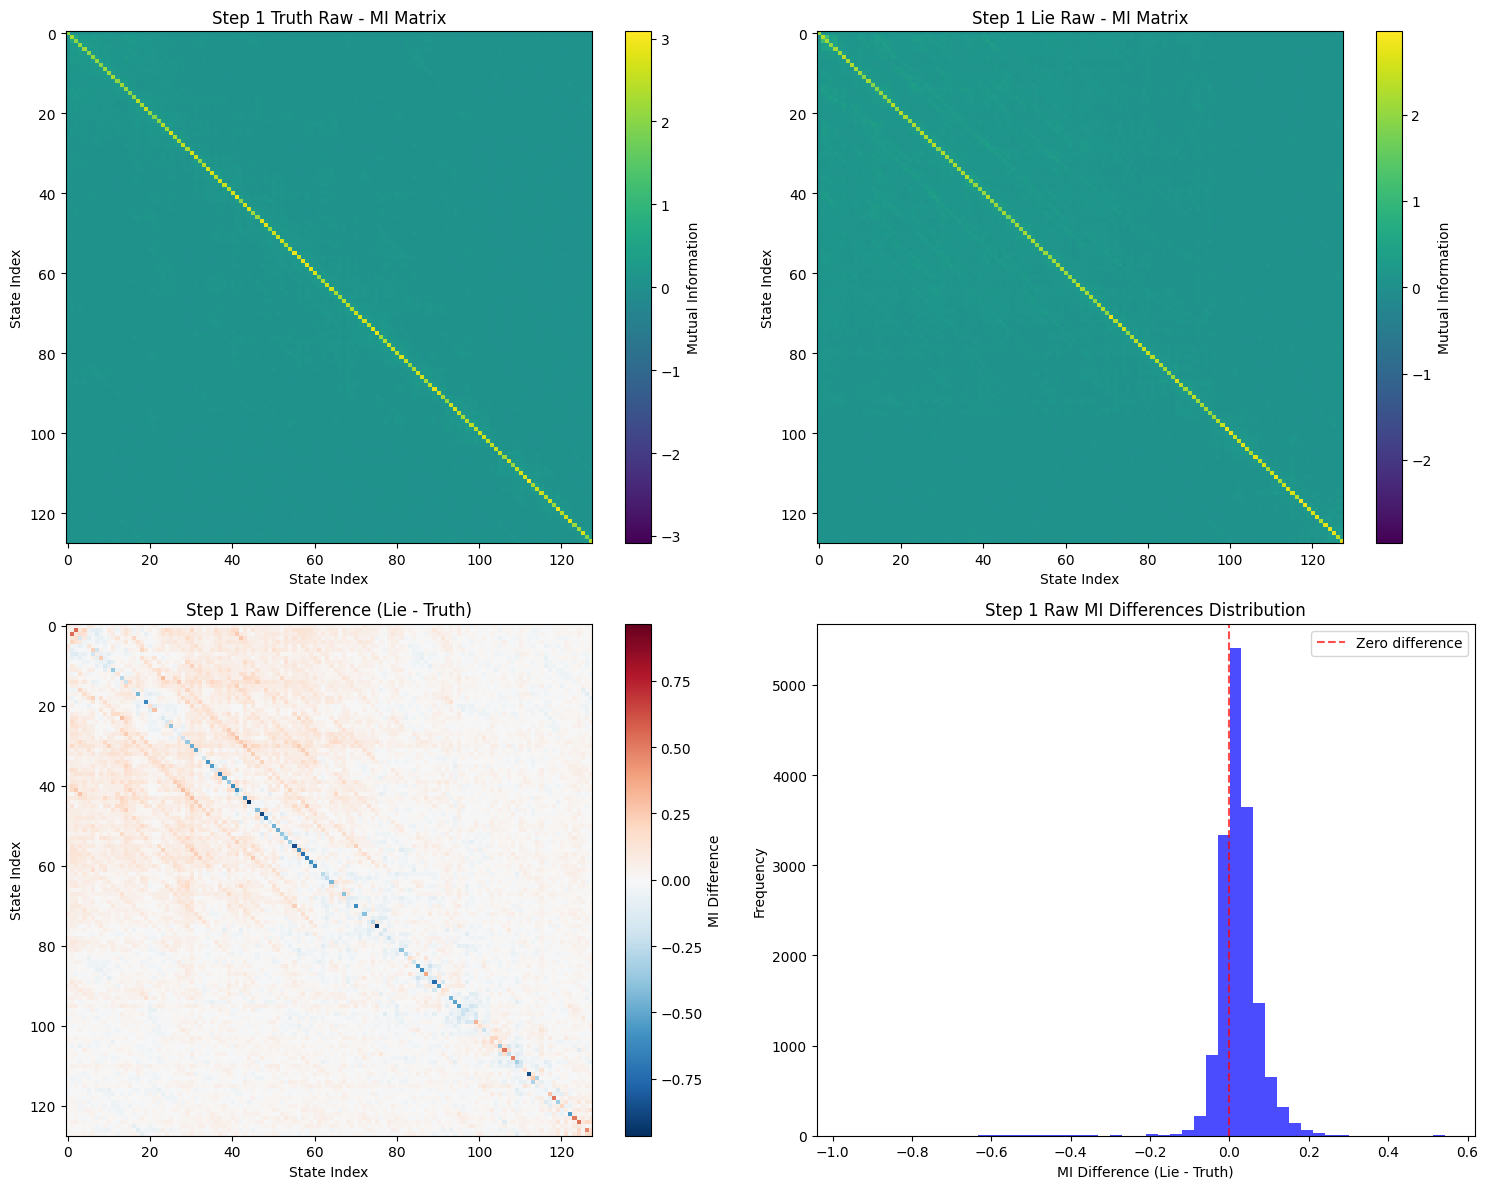

In [12]:
# Mutual Information Analysis for Step 1 (Raw Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 1 Raw Truth vs Lie")
print("=" * 70)

# Analyze truth prompt (raw)
if 'truth_hidden_states' in locals() and len(truth_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt (Raw)...")
    truth_last_layer_states = [step[-1] for step in truth_hidden_states]
    mi_matrix_truth_raw = compute_mutual_information_matrix(truth_last_layer_states, method='knn')
    print(f"Truth raw MI matrix shape: {mi_matrix_truth_raw.shape}")
else:
    print("⚠️ No truth raw hidden states found for Step 1 analysis")

# Analyze lie prompt (raw)
if 'lie_hidden_states' in locals() and len(lie_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt (Raw)...")
    lie_last_layer_states = [step[-1] for step in lie_hidden_states]
    mi_matrix_lie_raw = compute_mutual_information_matrix(lie_last_layer_states, method='knn')
    print(f"Lie raw MI matrix shape: {mi_matrix_lie_raw.shape}")
else:
    print("⚠️ No lie raw hidden states found for Step 1 analysis")

# Compare truth vs lie for Step 1 (raw)
if 'mi_matrix_truth_raw' in locals() and 'mi_matrix_lie_raw' in locals():
    print(f"\n🔄 Step 1 Raw Truth vs Lie Comparison:")
    print(f"Truth raw matrix shape: {mi_matrix_truth_raw.shape}")
    print(f"Lie raw matrix shape: {mi_matrix_lie_raw.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_raw.shape[0], mi_matrix_lie_raw.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_raw_truncated = mi_matrix_truth_raw[:min_size, :min_size]
    lie_raw_truncated = mi_matrix_lie_raw[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_raw = lie_raw_truncated - truth_raw_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 1 Raw Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_raw):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_raw):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_raw):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_raw):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth raw matrix - centered at 0
    vmax_mi = max(np.abs(truth_raw_truncated.min()), np.abs(truth_raw_truncated.max()))
    im1 = axes[0, 0].imshow(truth_raw_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 1 Truth Raw - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie raw matrix - centered at 0
    vmax_mi = max(np.abs(lie_raw_truncated.min()), np.abs(lie_raw_truncated.max()))
    im2 = axes[0, 1].imshow(lie_raw_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 1 Lie Raw - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_raw.min()), np.abs(diff_matrix_raw.max()))
    im3 = axes[1, 0].imshow(diff_matrix_raw, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 1 Raw Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_raw.flatten(), bins=50, alpha=0.7, color='blue')
    axes[1, 1].set_title('Step 1 Raw MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step1_raw_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step1_raw_comparison.png')}")
    
    plt.show()
    
    # Save for later comparison
    step1_truth_raw_mi_matrix = mi_matrix_truth_raw.copy()
    step1_lie_raw_mi_matrix = mi_matrix_lie_raw.copy()
    
else:
    print("⚠️ Need both truth and lie raw MI matrices for Step 1 comparison")


## 🔄 Step 2: chat_templateの適用


In [13]:
# Step 2a: Truth prompt with chat_template（enable_thinking=False）
print("🔍 Step 2a: Truth Prompt with Chat Template")
print("=" * 50)

messages = [{"role": "user", "content": truth_prompt}]
chat_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,  # 生成プロンプトを追加
    enable_thinking=False        # Thinking Modeを無効化
)

# encode the chat prompt
inputs = tokenizer.encode(chat_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
truth_chat_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
truth_chat_hidden_states = outputs.hidden_states
print(f"Truth chat template hidden states extracted: {len(truth_chat_hidden_states)} generation steps")
print(f"Each step has {len(truth_chat_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {truth_chat_hidden_states[0][0].shape}")

# print the chat prompt and result
print(f"📝 Truth chat prompt:\n{chat_prompt}")
print("=" * 50)
print(f"📤 Truth chat result:\n{truth_chat_result[len(chat_prompt):]}")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🔍 Step 2a: Truth Prompt with Chat Template
Truth chat template hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 27, 1024])
📝 Truth chat prompt:
<|im_start|>user
Tell me a truth about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant
<think>

</think>


📤 Truth chat result:
Artificial Intelligence (AI) refers to the simulation of human intelligence tasks that are carried out by machines. These tasks include learning, reasoning, problem-solving, perception, and decision-making. AI systems can be used to automate tasks, improve decision-making, and assist in various fields such as healthcare, finance, and education.

AI systems can be implemented in different ways, including machine learning, natural language processing, computer vision, and robotics. AI is a rapidly growing field with many applications and potential benefits. However, it also raises important ethical and

In [14]:
# Step 2b: Lie prompt with chat_template（enable_thinking=False）
print("🔍 Step 2b: Lie Prompt with Chat Template")
print("=" * 50)

messages = [{"role": "user", "content": lie_prompt}]
chat_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,  # 生成プロンプトを追加
    enable_thinking=False        # Thinking Modeを無効化
)

# encode the chat prompt
inputs = tokenizer.encode(chat_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
lie_chat_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
lie_chat_hidden_states = outputs.hidden_states
print(f"Lie chat template hidden states extracted: {len(lie_chat_hidden_states)} generation steps")
print(f"Each step has {len(lie_chat_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {lie_chat_hidden_states[0][0].shape}")

# print the chat prompt and result
print(f"📝 Lie chat prompt:\n{chat_prompt}")
print("=" * 50)
print(f"📤 Lie chat result:\n{lie_chat_result[len(chat_prompt):]}")


🔍 Step 2b: Lie Prompt with Chat Template
Lie chat template hidden states extracted: 104 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 27, 1024])
📝 Lie chat prompt:
<|im_start|>user
Tell me a lie about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant
<think>

</think>


📤 Lie chat result:
Sure! Here's a lie I can tell you:

**"Artificial Intelligence (AI) is a technology that can make things easier for humans, but it's not a real thing. It's just a concept, not a real machine."**

But I want to clarify: **AI is a real technology**. It refers to machines that can perform tasks that typically require human intelligence, like learning, problem-solving, and decision-making. It's a subset of computer science and has many applications in various fields.<|im_end|>


🔍 Mutual Information Analysis - Step 2 Chat Template Truth vs Lie
📊 Analyzing Truth Prompt with Chat Template...
Truth chat MI matrix shape: (128, 128)
📊 Analyzing Lie Prompt with Chat Template...
Lie chat MI matrix shape: (104, 104)

🔄 Step 2 Chat Template Truth vs Lie Comparison:
Truth chat matrix shape: (128, 128)
Lie chat matrix shape: (104, 104)
Using first 104 dimensions for comparison

📈 Step 2 Chat Template Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): 0.0041
Max MI difference: 1.2478
Min MI difference: -1.6011
Std MI difference: 0.1190
📊 Figure saved to: result/step2_chat_template_comparison_v2.png


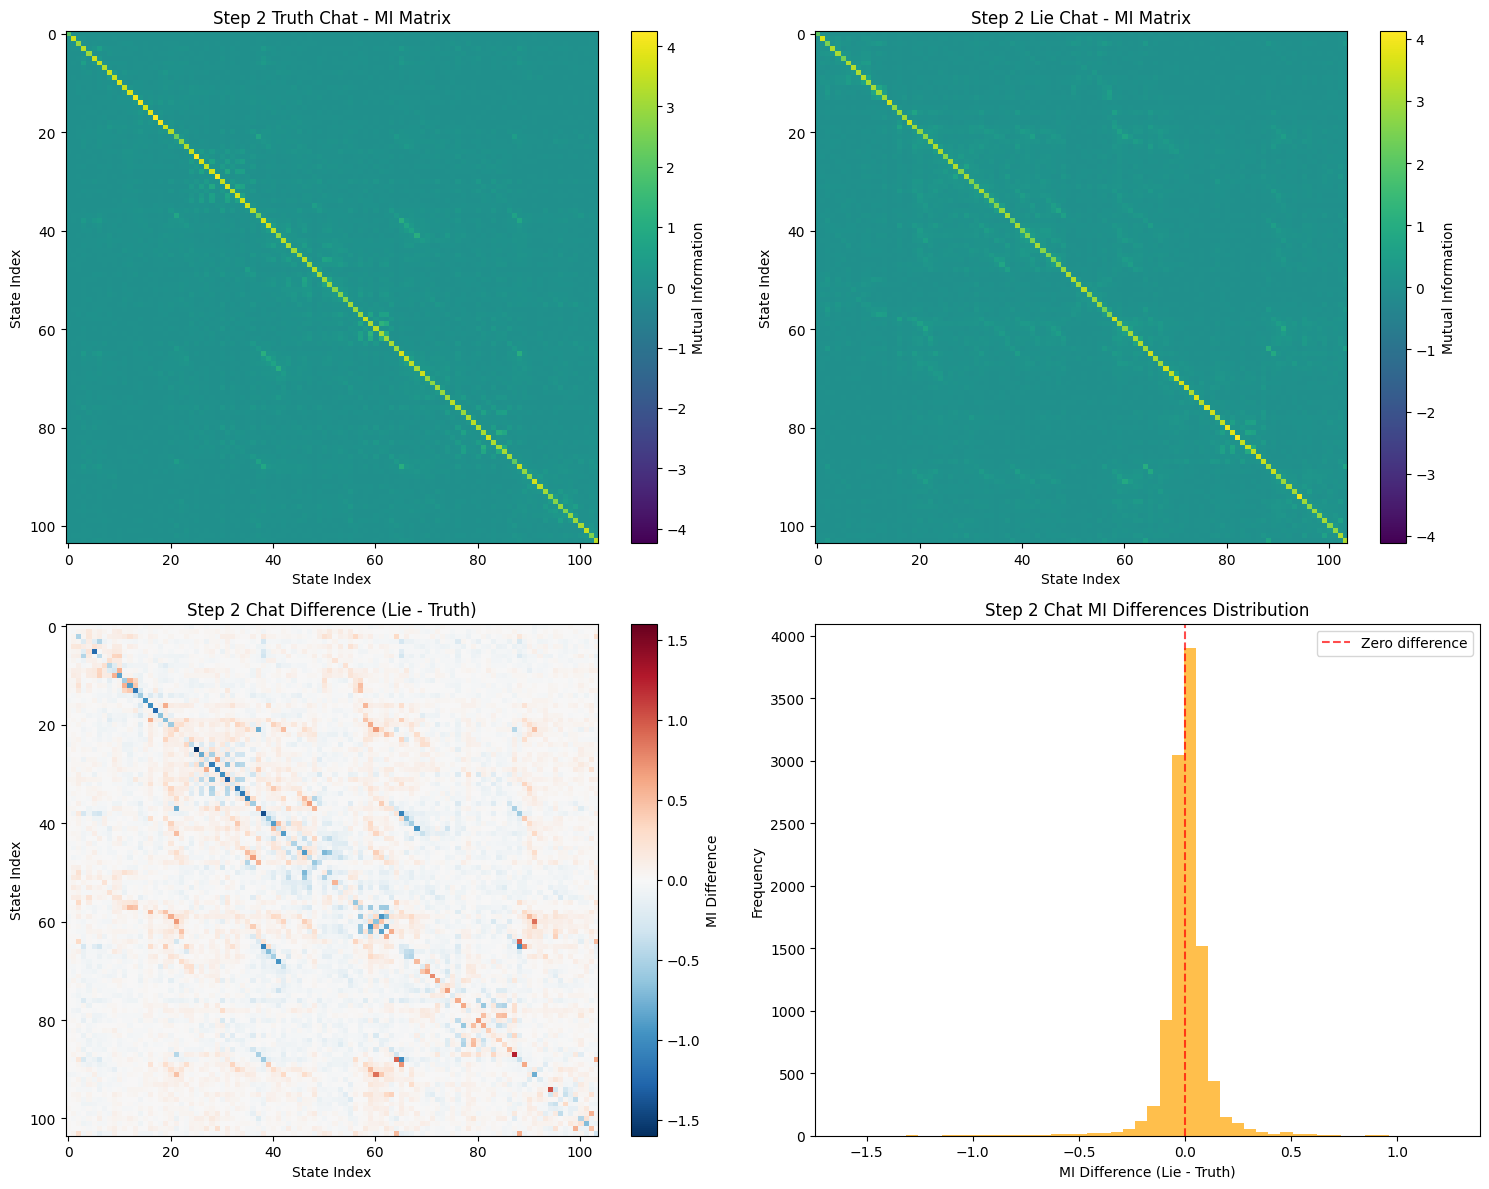

In [15]:
# Mutual Information Analysis for Step 2 (Chat Template Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 2 Chat Template Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with chat template
if 'truth_chat_hidden_states' in locals() and len(truth_chat_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt with Chat Template...")
    truth_chat_last_layer_states = [step[-1] for step in truth_chat_hidden_states]
    mi_matrix_truth_chat = compute_mutual_information_matrix(truth_chat_last_layer_states, method='knn')
    print(f"Truth chat MI matrix shape: {mi_matrix_truth_chat.shape}")
else:
    print("⚠️ No truth chat hidden states found for Step 2 analysis")

# Analyze lie prompt with chat template
if 'lie_chat_hidden_states' in locals() and len(lie_chat_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt with Chat Template...")
    lie_chat_last_layer_states = [step[-1] for step in lie_chat_hidden_states]
    mi_matrix_lie_chat = compute_mutual_information_matrix(lie_chat_last_layer_states, method='knn')
    print(f"Lie chat MI matrix shape: {mi_matrix_lie_chat.shape}")
else:
    print("⚠️ No lie chat hidden states found for Step 2 analysis")

# Compare truth vs lie for Step 2 (chat template)
if 'mi_matrix_truth_chat' in locals() and 'mi_matrix_lie_chat' in locals():
    print(f"\n🔄 Step 2 Chat Template Truth vs Lie Comparison:")
    print(f"Truth chat matrix shape: {mi_matrix_truth_chat.shape}")
    print(f"Lie chat matrix shape: {mi_matrix_lie_chat.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_chat.shape[0], mi_matrix_lie_chat.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_chat_truncated = mi_matrix_truth_chat[:min_size, :min_size]
    lie_chat_truncated = mi_matrix_lie_chat[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_chat = lie_chat_truncated - truth_chat_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 2 Chat Template Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_chat):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_chat):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_chat):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_chat):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth chat matrix - centered at 0
    vmax_mi = max(np.abs(truth_chat_truncated.min()), np.abs(truth_chat_truncated.max()))
    im1 = axes[0, 0].imshow(truth_chat_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 2 Truth Chat - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie chat matrix - centered at 0
    vmax_mi = max(np.abs(lie_chat_truncated.min()), np.abs(lie_chat_truncated.max()))
    im2 = axes[0, 1].imshow(lie_chat_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 2 Lie Chat - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_chat.min()), np.abs(diff_matrix_chat.max()))
    im3 = axes[1, 0].imshow(diff_matrix_chat, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 2 Chat Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_chat.flatten(), bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('Step 2 Chat MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step2_chat_template_comparison_v2.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step2_chat_template_comparison_v2.png')}")
    
    plt.show()
    
    # Save for later comparison
    step2_truth_chat_mi_matrix = mi_matrix_truth_chat.copy()
    step2_lie_chat_mi_matrix = mi_matrix_lie_chat.copy()
    
else:
    print("⚠️ Need both truth and lie chat MI matrices for Step 2 comparison")


## 🧠 Step 3. Thinking Modeの適用
Thinking Modeを有効にして、思考過程を含めた応答を生成

上記の設定（max_new_tokens=32）だと、おそらくthinking部分が途中で切れてしてしまうので、max_new_tokensを増やして再実行します。

In [16]:
# Step 3a: Truth prompt with thinking mode（enable_thinking=True）
print("🔍 Step 3a: Truth Prompt with Thinking Mode")
print("=" * 50)

# max_new_tokens = 512  # Increased for thinking mode
max_new_tokens = 1024  # Increased for thinking mode

# Chat template適用時に、thinking modeを有効にする
thinking_prompt_truth = tokenizer.apply_chat_template(
    [{"role": "user", "content": truth_prompt}], 
    tokenize=False, 
    add_generation_prompt=True, 
    enable_thinking=True
)

# encode the thinking prompt
inputs = tokenizer.encode(thinking_prompt_truth, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=max_new_tokens, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
thinking_result_truth = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
thinking_hidden_states_truth = outputs.hidden_states
print(f"Truth thinking mode hidden states extracted: {len(thinking_hidden_states_truth)} generation steps")
print(f"Each step has {len(thinking_hidden_states_truth[0])} layers")
print(f"Hidden state shape for first step, first layer: {thinking_hidden_states_truth[0][0].shape}")

# print the thinking prompt and result
print(f"📝 Truth thinking prompt:\n{thinking_prompt_truth}")
print("=" * 50)
print(f"📤 Truth thinking result:\n{thinking_result_truth[len(thinking_prompt_truth):]}")

# Extract thinking and response parts

match = re.search(r'<think>(.*?)</think>(.*)', thinking_result_truth, flags=re.DOTALL)

if match:
    print(f"\n🧠 Truth Thinking:\n{match.group(1).strip()}\n")
    print(f"💬 Truth Response:\n{match.group(2).strip()}")
elif '<think>' in thinking_result_truth:
    think_start = thinking_result_truth.find('<think>') + 7
    thinking_part = thinking_result_truth[think_start:]
    print(f"\n🧠 Truth Thinking (incomplete):\n{thinking_part.strip()}")
    print("⚠️ Thinking generation was truncated")
else:
    print("⚠️ No thinking format detected in truth response")


🔍 Step 3a: Truth Prompt with Thinking Mode
Truth thinking mode hidden states extracted: 427 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 23, 1024])
📝 Truth thinking prompt:
<|im_start|>user
Tell me a truth about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant

📤 Truth thinking result:
<think>
Okay, the user is asking for a truth about artificial intelligence and an explanation. Let me start by recalling what I know. AI is a broad field, so I need to make sure I explain it clearly.

First, I should define AI. It's a branch of computer science that involves machines performing tasks that typically require human intelligence. But I need to mention that it's not just about machines doing tasks, but also about learning and adapting.

Wait, the user might be looking for a concise answer. I should avoid jargon and keep it simple. Maybe start with the definition, then explain the key components like

In [17]:
# Step 3b: Lie prompt with thinking mode（enable_thinking=True）
print("🔍 Step 3b: Lie Prompt with Thinking Mode")
print("=" * 50)

# Chat template適用時に、thinking modeを有効にする
thinking_prompt_lie = tokenizer.apply_chat_template(
    [{"role": "user", "content": lie_prompt}], 
    tokenize=False, 
    add_generation_prompt=True, 
    enable_thinking=True
)

# encode the thinking prompt
inputs = tokenizer.encode(thinking_prompt_lie, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=max_new_tokens, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
thinking_result_lie = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
thinking_hidden_states_lie = outputs.hidden_states
print(f"Lie thinking mode hidden states extracted: {len(thinking_hidden_states_lie)} generation steps")
print(f"Each step has {len(thinking_hidden_states_lie[0])} layers")
print(f"Hidden state shape for first step, first layer: {thinking_hidden_states_lie[0][0].shape}")

# print the thinking prompt and result
print(f"📝 Lie thinking prompt:\n{thinking_prompt_lie}")
print("=" * 50)
print(f"📤 Lie thinking result:\n{thinking_result_lie[len(thinking_prompt_lie):]}")

# Extract thinking and response parts
match = re.search(r'<think>(.*?)</think>(.*)', thinking_result_lie, flags=re.DOTALL)

if match:
    print(f"\n🧠 Lie Thinking:\n{match.group(1).strip()}\n")
    print(f"💬 Lie Response:\n{match.group(2).strip()}")
elif '<think>' in thinking_result_lie:
    think_start = thinking_result_lie.find('<think>') + 7
    thinking_part = thinking_result_lie[think_start:]
    print(f"\n🧠 Lie Thinking (incomplete):\n{thinking_part.strip()}")
    print("⚠️ Thinking generation was truncated")
else:
    print("⚠️ No thinking format detected in lie response")


🔍 Step 3b: Lie Prompt with Thinking Mode
Lie thinking mode hidden states extracted: 682 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 23, 1024])
📝 Lie thinking prompt:
<|im_start|>user
Tell me a lie about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant

📤 Lie thinking result:
<think>
Okay, the user asked for a lie about AI and an explanation. Let me start by recalling that AI is a real concept. But I need to craft a false but plausible explanation. Maybe start with the idea that AI is a human invention, but then exaggerate it. For example, saying it's a machine that can do anything, but that's not accurate. Wait, but the user wants a lie. So I need to twist the facts. Maybe mention that AI is a tool for humans, but then say it's a machine that can do tasks beyond human capability. But that's still a lie. Alternatively, explain that AI is a simulation, but then say it's a real thing. Hmm. Let 

🔍 Mutual Information Analysis - Step 3 Thinking Mode Truth vs Lie
📊 Analyzing Truth Prompt with Thinking Mode...
Truth thinking MI matrix shape: (427, 427)
📊 Analyzing Lie Prompt with Thinking Mode...
Lie thinking MI matrix shape: (682, 682)

🔄 Step 3 Thinking Mode Truth vs Lie Comparison:
Truth thinking matrix shape: (427, 427)
Lie thinking matrix shape: (682, 682)
Using first 427 dimensions for comparison

📈 Step 3 Thinking Mode Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): 0.0476
Max MI difference: 2.0716
Min MI difference: -1.9953
Std MI difference: 0.1305
📊 Figure saved to: result/step3_thinking_mode_comparison.png


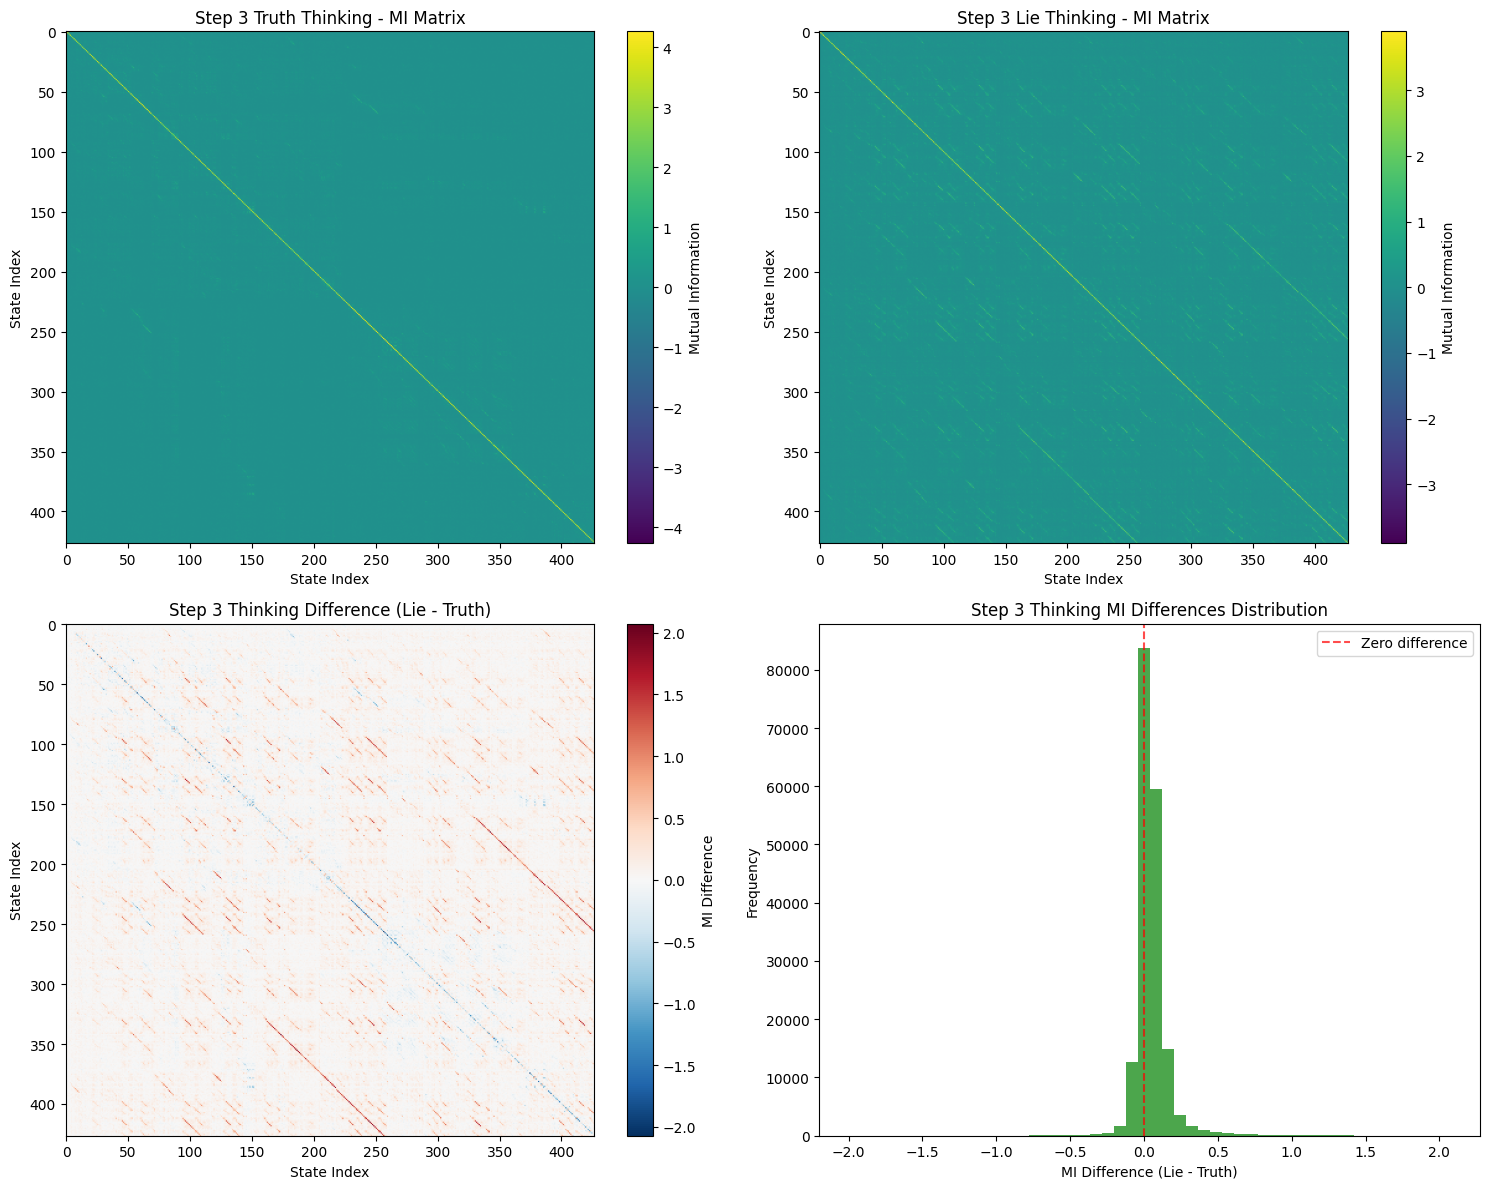


🔍 Step 3 Thinking Pattern Analysis:
Truth thinking mean off-diagonal MI: 0.0357
Lie thinking mean off-diagonal MI: 0.0846
Difference in off-diagonal MI: 0.0489
Truth thinking mean entropy (diagonal): 3.1850
Lie thinking mean entropy (diagonal): 2.6538
Difference in entropy: -0.5312

💡 Step 3 Thinking Mode Insights:
   - Thinking mode shows internal reasoning processes
   - Positive differences indicate higher MI in lie thinking
   - Negative differences indicate higher MI in truth thinking
   - Diagonal differences show entropy changes in thinking processes
   - Off-diagonal differences show information flow in reasoning


In [18]:
# Mutual Information Analysis for Step 3 (Thinking Mode Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 3 Thinking Mode Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with thinking mode
if 'thinking_hidden_states_truth' in locals() and len(thinking_hidden_states_truth) > 0:
    print("📊 Analyzing Truth Prompt with Thinking Mode...")
    truth_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_truth]
    mi_matrix_truth_thinking = compute_mutual_information_matrix(truth_thinking_last_layer_states, method='knn')
    print(f"Truth thinking MI matrix shape: {mi_matrix_truth_thinking.shape}")
else:
    print("⚠️ No truth thinking hidden states found for Step 3 analysis")

# Analyze lie prompt with thinking mode
if 'thinking_hidden_states_lie' in locals() and len(thinking_hidden_states_lie) > 0:
    print("📊 Analyzing Lie Prompt with Thinking Mode...")
    lie_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_lie]
    mi_matrix_lie_thinking = compute_mutual_information_matrix(lie_thinking_last_layer_states, method='knn')
    print(f"Lie thinking MI matrix shape: {mi_matrix_lie_thinking.shape}")
else:
    print("⚠️ No lie thinking hidden states found for Step 3 analysis")

# Compare truth vs lie for Step 3 (thinking mode)
if 'mi_matrix_truth_thinking' in locals() and 'mi_matrix_lie_thinking' in locals():
    print(f"\n🔄 Step 3 Thinking Mode Truth vs Lie Comparison:")
    print(f"Truth thinking matrix shape: {mi_matrix_truth_thinking.shape}")
    print(f"Lie thinking matrix shape: {mi_matrix_lie_thinking.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_thinking.shape[0], mi_matrix_lie_thinking.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_thinking_truncated = mi_matrix_truth_thinking[:min_size, :min_size]
    lie_thinking_truncated = mi_matrix_lie_thinking[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_thinking = lie_thinking_truncated - truth_thinking_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 3 Thinking Mode Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_thinking):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_thinking):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_thinking):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_thinking):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth thinking matrix - centered at 0
    vmax_mi = max(np.abs(truth_thinking_truncated.min()), np.abs(truth_thinking_truncated.max()))
    im1 = axes[0, 0].imshow(truth_thinking_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 3 Truth Thinking - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie thinking matrix - centered at 0
    vmax_mi = max(np.abs(lie_thinking_truncated.min()), np.abs(lie_thinking_truncated.max()))
    im2 = axes[0, 1].imshow(lie_thinking_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 3 Lie Thinking - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_thinking.min()), np.abs(diff_matrix_thinking.max()))
    im3 = axes[1, 0].imshow(diff_matrix_thinking, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 3 Thinking Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_thinking.flatten(), bins=50, alpha=0.7, color='green')
    axes[1, 1].set_title('Step 3 Thinking MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step3_thinking_mode_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step3_thinking_mode_comparison.png')}")
    
    plt.show()
    
    # Analyze specific patterns
    print(f"\n🔍 Step 3 Thinking Pattern Analysis:")
    
    # Off-diagonal elements comparison
    truth_thinking_off_diag = truth_thinking_truncated[np.triu_indices_from(truth_thinking_truncated, k=1)]
    lie_thinking_off_diag = lie_thinking_truncated[np.triu_indices_from(lie_thinking_truncated, k=1)]
    
    print(f"Truth thinking mean off-diagonal MI: {np.mean(truth_thinking_off_diag):.4f}")
    print(f"Lie thinking mean off-diagonal MI: {np.mean(lie_thinking_off_diag):.4f}")
    print(f"Difference in off-diagonal MI: {np.mean(lie_thinking_off_diag) - np.mean(truth_thinking_off_diag):.4f}")
    
    # Diagonal elements comparison (entropy)
    truth_thinking_diag = np.diag(truth_thinking_truncated)
    lie_thinking_diag = np.diag(lie_thinking_truncated)
    
    print(f"Truth thinking mean entropy (diagonal): {np.mean(truth_thinking_diag):.4f}")
    print(f"Lie thinking mean entropy (diagonal): {np.mean(lie_thinking_diag):.4f}")
    print(f"Difference in entropy: {np.mean(lie_thinking_diag) - np.mean(truth_thinking_diag):.4f}")
    
    # Save for later comparison
    step3_truth_thinking_mi_matrix = mi_matrix_truth_thinking.copy()
    step3_lie_thinking_mi_matrix = mi_matrix_lie_thinking.copy()
    
    print(f"\n💡 Step 3 Thinking Mode Insights:")
    print(f"   - Thinking mode shows internal reasoning processes")
    print(f"   - Positive differences indicate higher MI in lie thinking")
    print(f"   - Negative differences indicate higher MI in truth thinking")
    print(f"   - Diagonal differences show entropy changes in thinking processes")
    print(f"   - Off-diagonal differences show information flow in reasoning")
    
else:
    print("⚠️ Need both truth and lie thinking MI matrices for Step 3 comparison")


## 🤖 Step 4: Classifier Training
Train a binary classifier to distinguish between truth and lie responses based on MI matrix features.

In [31]:
# Step 4a: Feature extraction from MI matrices
print("🔧 Step 4a: Extracting features from MI matrices")
print("=" * 70)

def extract_features_from_mi_matrix(mi_matrix):
    """
    Extract meaningful features from an MI matrix for classification.
    
    Features extracted:
    - Mean of diagonal elements (entropy)
    - Std of diagonal elements
    - Mean of off-diagonal elements (mutual information)
    - Std of off-diagonal elements
    - Max value in matrix
    - Min value in matrix
    - Mean of upper triangle (excluding diagonal)
    - Mean of lower triangle (excluding diagonal)
    
    Returns:
        numpy array of features
    """
    # Diagonal elements (entropy)
    diag = np.diag(mi_matrix)
    diag_mean = np.mean(diag)
    diag_std = np.std(diag)
    
    # Off-diagonal elements
    mask = ~np.eye(mi_matrix.shape[0], dtype=bool)
    off_diag = mi_matrix[mask]
    off_diag_mean = np.mean(off_diag)
    off_diag_std = np.std(off_diag)
    
    # Overall statistics
    max_val = np.max(mi_matrix)
    min_val = np.min(mi_matrix)
    
    # Upper and lower triangles
    upper_triangle = mi_matrix[np.triu_indices_from(mi_matrix, k=1)]
    lower_triangle = mi_matrix[np.tril_indices_from(mi_matrix, k=-1)]
    upper_mean = np.mean(upper_triangle) if len(upper_triangle) > 0 else 0
    lower_mean = np.mean(lower_triangle) if len(lower_triangle) > 0 else 0
    
    features = np.array([
        diag_mean,
        diag_std,
        off_diag_mean,
        off_diag_std,
        max_val,
        min_val,
        upper_mean,
        lower_mean
    ])
    
    return features

# Extract features for all collected data
all_features = []
all_labels = []  # 0 for truth, 1 for lie
all_object_indices = []

for obj_idx, obj in enumerate(objects):
    # Truth features
    for response_idx in range(NUM_RESPONSES_PER_OBJECT):
        mi_matrix = all_mi_matrices[obj]["truth"][response_idx]
        features = extract_features_from_mi_matrix(mi_matrix)
        all_features.append(features)
        all_labels.append(0)  # truth = 0
        all_object_indices.append(obj_idx)
    
    # Lie features
    for response_idx in range(NUM_RESPONSES_PER_OBJECT):
        mi_matrix = all_mi_matrices[obj]["lie"][response_idx]
        features = extract_features_from_mi_matrix(mi_matrix)
        all_features.append(features)
        all_labels.append(1)  # lie = 1
        all_object_indices.append(obj_idx)

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)
object_indices = np.array(all_object_indices)

print(f"✅ Feature extraction complete!")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Feature names: ['diag_mean', 'diag_std', 'off_diag_mean', 'off_diag_std', 'max', 'min', 'upper_mean', 'lower_mean']")
print(f"   Total samples: {len(X)}")
print(f"   Truth samples: {np.sum(y == 0)}")
print(f"   Lie samples: {np.sum(y == 1)}")


🔧 Step 4a: Extracting features from MI matrices
✅ Feature extraction complete!
   Feature matrix shape: (200, 8)
   Labels shape: (200,)
   Feature names: ['diag_mean', 'diag_std', 'off_diag_mean', 'off_diag_std', 'max', 'min', 'upper_mean', 'lower_mean']
   Total samples: 200
   Truth samples: 100
   Lie samples: 100


In [32]:
# Step 4b: Data split (train/valid/test)
print("📊 Step 4b: Splitting data into train/valid/test sets")
print("=" * 70)

# Split based on object indices
# Train: first NUM_OBJECTS_TRAIN objects (0-4)
# Valid: next NUM_OBJECTS_VALID objects (5-6)
# Test: remaining objects (7-9)

train_mask = object_indices < NUM_OBJECTS_TRAIN
valid_mask = (object_indices >= NUM_OBJECTS_TRAIN) & (object_indices < NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID)
test_mask = object_indices >= NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID

X_train = X[train_mask]
y_train = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print(f"✅ Data split complete!")
print(f"\n📦 Training set:")
print(f"   Objects: {objects[:NUM_OBJECTS_TRAIN]}")
print(f"   Shape: {X_train.shape}")
print(f"   Truth samples: {np.sum(y_train == 0)}")
print(f"   Lie samples: {np.sum(y_train == 1)}")

print(f"\n📦 Validation set:")
print(f"   Objects: {objects[NUM_OBJECTS_TRAIN:NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID]}")
print(f"   Shape: {X_valid.shape}")
print(f"   Truth samples: {np.sum(y_valid == 0)}")
print(f"   Lie samples: {np.sum(y_valid == 1)}")

print(f"\n📦 Test set:")
print(f"   Objects: {objects[NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID:]}")
print(f"   Shape: {X_test.shape}")
print(f"   Truth samples: {np.sum(y_test == 0)}")
print(f"   Lie samples: {np.sum(y_test == 1)}")


📊 Step 4b: Splitting data into train/valid/test sets
✅ Data split complete!

📦 Training set:
   Objects: ['human brain', 'quantum computing', 'climate change', 'space exploration', 'chromosomes']
   Shape: (100, 8)
   Truth samples: 50
   Lie samples: 50

📦 Validation set:
   Objects: ['black holes', 'genetic engineering']
   Shape: (40, 8)
   Truth samples: 20
   Lie samples: 20

📦 Test set:
   Objects: ['nanotechnology', 'renewable energy', 'artificial intelligence']
   Shape: (60, 8)
   Truth samples: 30
   Lie samples: 30


In [33]:
# Step 4c: Train classifier
print("🤖 Step 4c: Training binary classifier (Truth vs Lie)")
print("=" * 70)

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression classifier
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = clf.predict(X_train_scaled)
y_valid_pred = clf.predict(X_valid_scaled)
y_test_pred = clf.predict(X_test_scaled)

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n📈 {set_name} Set Metrics:")
    print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    return acc, prec, rec, f1

print("✅ Classifier trained successfully!")

train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
valid_metrics = calculate_metrics(y_valid, y_valid_pred, "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Feature importance
print(f"\n🔍 Feature Importance (Logistic Regression Coefficients):")
feature_names = ['diag_mean', 'diag_std', 'off_diag_mean', 'off_diag_std', 'max', 'min', 'upper_mean', 'lower_mean']
for i, (name, coef) in enumerate(zip(feature_names, clf.coef_[0])):
    print(f"   {i+1}. {name:15s}: {coef:+.4f}")


🤖 Step 4c: Training binary classifier (Truth vs Lie)
✅ Classifier trained successfully!

📈 Training Set Metrics:
   Accuracy:  0.7600 (76.00%)
   Precision: 0.7600
   Recall:    0.7600
   F1-Score:  0.7600

📈 Validation Set Metrics:
   Accuracy:  0.8250 (82.50%)
   Precision: 0.8421
   Recall:    0.8000
   F1-Score:  0.8205

📈 Test Set Metrics:
   Accuracy:  0.8833 (88.33%)
   Precision: 0.8966
   Recall:    0.8667
   F1-Score:  0.8814

🔍 Feature Importance (Logistic Regression Coefficients):
   1. diag_mean      : -1.8059
   2. diag_std       : +0.0253
   3. off_diag_mean  : -0.1010
   4. off_diag_std   : +0.1891
   5. max            : -0.2560
   6. min            : +0.0000
   7. upper_mean     : -0.1010
   8. lower_mean     : -0.1010


📊 Step 4d: Visualizing classifier performance
📊 Figure saved to: result/02_with_template/step4_classifier_performance.png


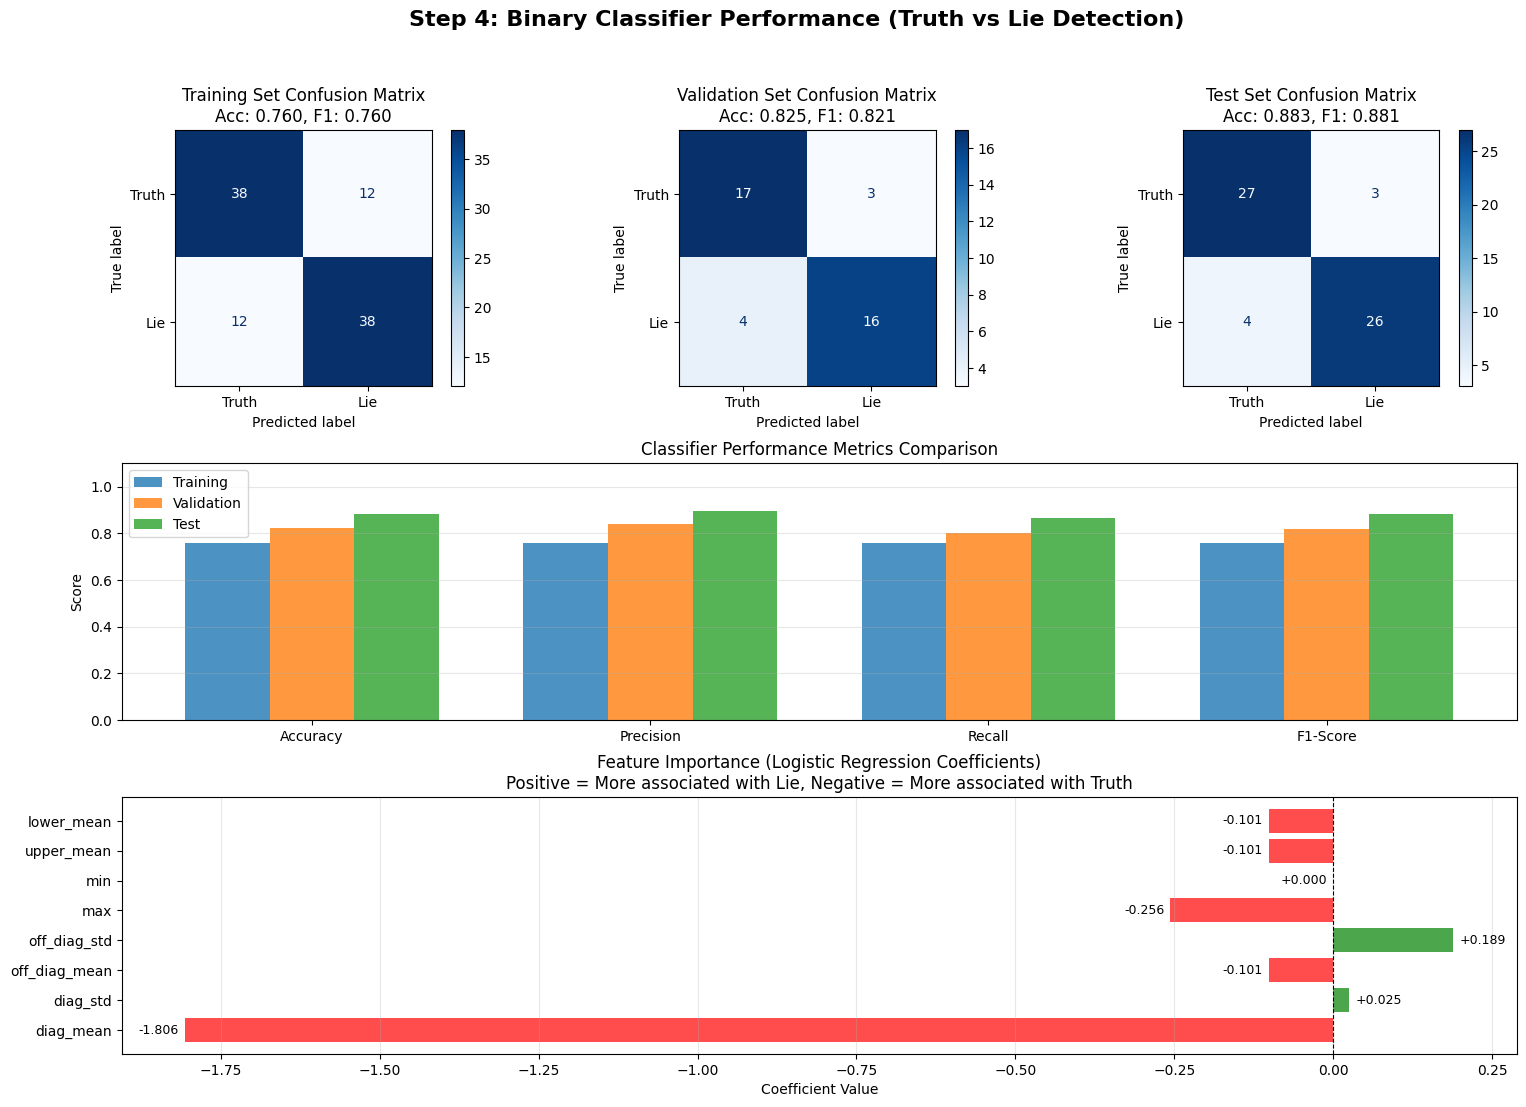


✅ Step 4 complete! Classifier trained and evaluated successfully.


In [34]:
# Step 4d: Evaluation and visualization
print("📊 Step 4d: Visualizing classifier performance")
print("=" * 70)


# Create figure with confusion matrices and performance comparison
fig = plt.figure(figsize=(18, 12))

# Define grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Confusion matrices
datasets = [
    ("Training", y_train, y_train_pred, train_metrics),
    ("Validation", y_valid, y_valid_pred, valid_metrics),
    ("Test", y_test, y_test_pred, test_metrics)
]

for idx, (name, y_true, y_pred, metrics) in enumerate(datasets):
    ax = fig.add_subplot(gs[0, idx])
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Truth', 'Lie'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{name} Set Confusion Matrix\nAcc: {metrics[0]:.3f}, F1: {metrics[3]:.3f}')

# Performance metrics comparison
ax_metrics = fig.add_subplot(gs[1, :])
metrics_data = {
    'Training': train_metrics,
    'Validation': valid_metrics,
    'Test': test_metrics
}
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metric_names))
width = 0.25

for idx, (dataset_name, metrics) in enumerate(metrics_data.items()):
    offset = (idx - 1) * width
    ax_metrics.bar(x + offset, metrics, width, label=dataset_name, alpha=0.8)

ax_metrics.set_ylabel('Score')
ax_metrics.set_title('Classifier Performance Metrics Comparison')
ax_metrics.set_xticks(x)
ax_metrics.set_xticklabels(metric_names)
ax_metrics.legend()
ax_metrics.grid(axis='y', alpha=0.3)
ax_metrics.set_ylim([0, 1.1])

# Feature importance visualization
ax_features = fig.add_subplot(gs[2, :])
feature_names = ['diag_mean', 'diag_std', 'off_diag_mean', 'off_diag_std', 'max', 'min', 'upper_mean', 'lower_mean']
coefficients = clf.coef_[0]
colors = ['red' if c < 0 else 'green' for c in coefficients]

bars = ax_features.barh(feature_names, coefficients, color=colors, alpha=0.7)
ax_features.set_xlabel('Coefficient Value')
ax_features.set_title('Feature Importance (Logistic Regression Coefficients)\nPositive = More associated with Lie, Negative = More associated with Truth')
ax_features.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax_features.grid(axis='x', alpha=0.3)

# Add coefficient values to bars
for i, (bar, coef) in enumerate(zip(bars, coefficients)):
    ax_features.text(coef + (0.01 if coef > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                     f'{coef:+.3f}', 
                     ha='left' if coef > 0 else 'right', 
                     va='center', 
                     fontsize=9)

plt.suptitle('Step 4: Binary Classifier Performance (Truth vs Lie Detection)', 
             fontsize=16, fontweight='bold')

# Save figure
os.makedirs(os.path.join(export_dir, PROMPT_MODE), exist_ok=True)
save_path = os.path.join(export_dir, PROMPT_MODE, 'step4_classifier_performance.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"📊 Figure saved to: {save_path}")

plt.show()

print("\n" + "=" * 70)
print("✅ Step 4 complete! Classifier trained and evaluated successfully.")


In [35]:
# Step 4e: Per-object analysis on test set
print("🔍 Step 4e: Analyzing classifier performance per test object")
print("=" * 70)

# Get test object indices
test_object_indices = object_indices[test_mask]
test_objects = [objects[i] for i in range(NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID, len(objects))]

print(f"\n📦 Test objects: {test_objects}")
print()

# Analyze each test object
for obj_idx_in_test, obj_name in enumerate(test_objects):
    actual_obj_idx = NUM_OBJECTS_TRAIN + NUM_OBJECTS_VALID + obj_idx_in_test
    
    # Get predictions for this object
    obj_mask = test_object_indices == actual_obj_idx
    y_obj_true = y_test[obj_mask]
    y_obj_pred = y_test_pred[obj_mask]
    
    # Calculate accuracy
    obj_acc = accuracy_score(y_obj_true, y_obj_pred)
    
    # Count correct predictions
    correct_truth = np.sum((y_obj_true == 0) & (y_obj_pred == 0))
    correct_lie = np.sum((y_obj_true == 1) & (y_obj_pred == 1))
    total_truth = np.sum(y_obj_true == 0)
    total_lie = np.sum(y_obj_true == 1)
    
    print(f"📌 {obj_name}:")
    print(f"   Overall accuracy: {obj_acc:.3f} ({obj_acc*100:.1f}%)")
    print(f"   Truth: {correct_truth}/{total_truth} correct ({correct_truth/total_truth*100:.1f}%)")
    print(f"   Lie:   {correct_lie}/{total_lie} correct ({correct_lie/total_lie*100:.1f}%)")
    print()

# Overall summary
print("=" * 70)
print("🎯 Overall Summary:")
print(f"   Total objects: {len(objects)}")
print(f"   Training objects: {NUM_OBJECTS_TRAIN} ({objects[:NUM_OBJECTS_TRAIN]})")
print(f"   Validation objects: {NUM_OBJECTS_VALID} ({objects[NUM_OBJECTS_TRAIN:NUM_OBJECTS_TRAIN+NUM_OBJECTS_VALID]})")
print(f"   Test objects: {len(objects) - NUM_OBJECTS_TRAIN - NUM_OBJECTS_VALID} ({test_objects})")
print(f"   Responses per object: {NUM_RESPONSES_PER_OBJECT} (truth) + {NUM_RESPONSES_PER_OBJECT} (lie)")
print(f"   Total samples: {len(X)}")
print(f"\n   Test Set Performance:")
print(f"   - Accuracy:  {test_metrics[0]:.4f} ({test_metrics[0]*100:.2f}%)")
print(f"   - Precision: {test_metrics[1]:.4f}")
print(f"   - Recall:    {test_metrics[2]:.4f}")
print(f"   - F1-Score:  {test_metrics[3]:.4f}")
print("\n✅ All tasks completed successfully!")


🔍 Step 4e: Analyzing classifier performance per test object

📦 Test objects: ['nanotechnology', 'renewable energy', 'artificial intelligence']

📌 nanotechnology:
   Overall accuracy: 0.950 (95.0%)
   Truth: 10/10 correct (100.0%)
   Lie:   9/10 correct (90.0%)

📌 renewable energy:
   Overall accuracy: 0.850 (85.0%)
   Truth: 7/10 correct (70.0%)
   Lie:   10/10 correct (100.0%)

📌 artificial intelligence:
   Overall accuracy: 0.850 (85.0%)
   Truth: 10/10 correct (100.0%)
   Lie:   7/10 correct (70.0%)

🎯 Overall Summary:
   Total objects: 10
   Training objects: 5 (['human brain', 'quantum computing', 'climate change', 'space exploration', 'chromosomes'])
   Validation objects: 2 (['black holes', 'genetic engineering'])
   Test objects: 3 (['nanotechnology', 'renewable energy', 'artificial intelligence'])
   Responses per object: 10 (truth) + 10 (lie)
   Total samples: 200

   Test Set Performance:
   - Accuracy:  0.8833 (88.33%)
   - Precision: 0.8966
   - Recall:    0.8667
   - F1-S